### PyMC を用いたベイズ推定の講義

**PyMC の概要**

*   **PyMC** は、Python でベイズ統計モデリングを行うための**オープンソースのフレームワーク**です。
*   **確率プログラミング**のパラダイムに基づいており、柔軟なモデル記述と自動的なベイズ推論が可能です。
*   **PyTensor** というライブラリを利用して、モデルの計算グラフを構築し、**勾配計算を自動化**しています。
    *   これにより、複雑なモデルでも効率的にサンプリングを行うことができます。
    *   PyTensor は、**NumPy の ndarray データ構造と密接に統合**されており、ブロードキャストや高度なインデックス操作が可能です。
*   PyMC は、**ハミルトニアンモンテカルロ (HMC)** やその自己調整版である **No-U-Turn Sampler (NUTS)** などの高度な MCMC アルゴリズムを実装しています。
    *   これらのサンプラーは、高次元で複雑な事後分布を持つモデルでも効率的に適合させることができます。
    *   **NUTS は、アルゴリズムの調整可能なパラメータを適応的に設定**するため、特別な知識がなくても使用できます。

**PyMC の基本的なステップ**

PyMC を使ったベイズ推定は、以下のステップで進められます。

1.  **モデルの定義**
    *   PyMC の `Model` オブジェクトを作成し、その中で**確率変数**（確率分布を持つ変数）を定義します。
    *   確率変数には、**事前分布**、**尤度関数**、**観測データ**などを指定します。
    *   確率変数は、`pm.Normal`, `pm.HalfNormal`, `pm.Bernoulli` などの確率分布オブジェクトを使用して定義します。
        *   `shape` 引数で、変数の次元を指定できます。
    *   `with` 文を使うことで、モデルコンテキスト内で定義された変数が自動的にモデルに追加されます。
2.  **モデルのサンプリング**
    *   `pm.sample()` 関数を使って、**事後分布からのサンプルを生成**します。
    *   デフォルトでは NUTS サンプラーが使用されますが、他のサンプラー（`pm.Metropolis`, `pm.Slice` など）も指定できます。
    *   サンプリングの結果は、**InferenceData** オブジェクトに格納されます。
3.  **事後分析**
    *   **ArviZ** というパッケージを使って、サンプリング結果を可視化したり、統計量を計算したりします。
    *   `az.plot_trace()` で、事後分布の軌跡や密度をプロットできます。
    *   `az.summary()` で、事後分布の統計量（平均、標準偏差、信頼区間など）を確認できます。
    *   **事後予測チェック $PPC)** を行って、モデルの妥当性を検証します。
        *   `pm.sample_posterior_predictive()` 関数で、事後分布から予測データを生成できます。

**簡単な例**

まずは、簡単な線形回帰モデルを PyMC で実装してみましょう。
$$
\begin{aligned}
Y_i \sim \mathcal{N}(\mu_i, \sigma^2) \\
\mu_i = \alpha + \beta X_i
\end{aligned}
$$

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

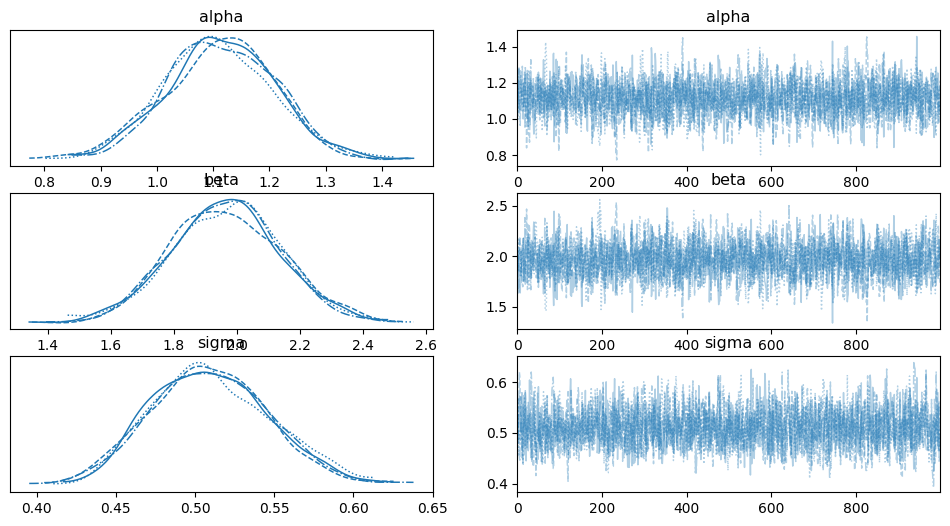

In [7]:
import pymc as pm
import numpy as np
import arviz as az

# データの生成
np.random.seed(0)
X = np.random.rand(100)
Y = 2 * X + 1 + np.random.randn(100) * 0.5

# モデルの定義
with pm.Model() as model:
    # 事前分布
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # 期待値
    mu = alpha + beta * X

    # 尤度関数
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

    # サンプリング
    trace = pm.sample(1000)

# 事後分析
az.plot_trace(trace)


この例では、以下の手順でモデルを定義しています。

1.  `pm.Model()` でモデルオブジェクトを作成します。
2.  `pm.Normal` で、切片 (`alpha`) と傾き (`beta`) の事前分布を定義します。
    *   `mu` は平均、`sigma` は標準偏差を表します。
3.  `pm.HalfNormal` で、誤差の標準偏差 (`sigma`) の事前分布を定義します。
    *   `HalfNormal` は、正の値のみを取る分布です。
4.  `mu = alpha + beta * X` で、期待値を計算します。
5.  `pm.Normal` で、観測データ (`Y`) の尤度関数を定義します。
    *   `observed` 引数に、観測データを渡します。
6.  `pm.sample()` で、事後分布からのサンプルを生成します。
7.  `az.plot_trace()` で、サンプリング結果を可視化します。

**次回のステップ**

今日は PyMC の基本的な概念と、簡単な線形回帰モデルの実装を学びました。次回は、より複雑なモデル（例えば、階層ベイズモデルや一般化線形モデル）の実装や、モデル比較、予測など、より高度なトピックを掘り下げていく予定です。

### PyMCにおける確率分布の次元 (Distribution Dimensionality)

PyMCでは、確率分布の次元を柔軟に扱うことができます。これは、**モデルをより複雑にし、現実世界のデータをより正確に表現するために重要な概念**です。PyMCにおける次元は、以下の4つの主要なタイプに分類できます。

1.  **サポート次元 (Support Dimensions)**:

    *   **分布の基本的な次元**を表します。
    *   例えば、**一変量正規分布**の場合、サポート次元は **1次元** です。**多変量正規分布**の場合、サポート次元は変数の数に応じた次元数になります。
    *   これは、**確率変数が取りうる値の空間**の次元を示しています。
    *   例：`pm.Normal("x", mu=0, sigma=1)` の場合、`x` のサポート次元は1です。

2.  **バッチ次元 (Batch Dimensions)**:

    *   **サポート次元を超えた追加の次元**を表します。
    *   これは、**複数の独立した確率変数を一度に定義する**ために使用されます。
    *   例えば、同じパラメータを持つ複数の正規分布を定義する場合に使用します。
    *   例：`pm.Normal("x", mu=0, sigma=1, shape=3)` の場合、`x` は3つの独立した正規分布を表し、バッチ次元は1です。

3.  **暗黙的な次元 (Implicit Dimensions)**:

    *   **分布のパラメータの値や形状から自動的に決定される次元**です。
    *   例えば、パラメータとして与えられたテンソルの形状が、暗黙的な次元を決定します。
     *   例： `mu = pm.Normal("mu", mu=0, sigma=1, shape=(3,)); y = pm.Normal("y", mu=mu, sigma=1)` の場合、`y` は`mu`と同じ形状を持ち、暗黙的な次元は1です。
    *   明示的に指定しなくても、PyMCが自動的に形状を推論してくれます。

4.  **明示的な次元 (Explicit Dimensions)**:

    *   **`shape`、`dims`、`coords`引数**を使用して、明示的に定義される次元です。
    *   **`shape`**: 分布からのドロー数 (サンプル数) を指定します。
         * 例えば、`shape=3`と指定した場合、3つの独立したサンプルが生成されます。
    *   **`dims`**: 次元に名前を付けます。
         *  これにより、ArviZなどのライブラリで、モデルの結果を解釈しやすくなります。
         *  例：`dims="predictors"`とすると、その次元が "predictors" という名前で参照できるようになります。
    *   **`coords`**: 次元名と座標値を対応させる辞書を指定します。
        *  これにより、特定の座標値に沿って結果を分析できます。

### 具体例とコード

以下に、これらの概念を理解するための具体的な例を挙げます。

#### Univariate distribution example (一変量分布の例)

In [8]:
import pymc as pm
import numpy as np

# モデル外で分布を指定
x = pm.Normal.dist(mu=0, sigma=1)

この例では、`x`は**サポート次元が1の**一変量正規分布です。

#### Inspecting dimensionality with a model graph (モデルグラフで次元を調べる)


          x: shape=(3,)
sigma_log__: shape=()
      sigma: shape=()
          y: shape=(3,)


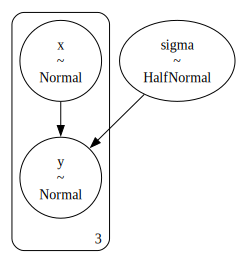

In [11]:
import pymc as pm

with pm.Model() as pmodel:
    mu = pm.Normal("x", mu=0, shape=(3)) # shape=(3,) はバッチ次元を指定
    sigma = pm.HalfNormal("sigma")
    y = pm.Normal("y", mu=mu, sigma=sigma)

    for rv, shape in pmodel.eval_rv_shapes().items():
        print(f"{rv:>11}: shape={shape}")

pm.model_to_graphviz(pmodel)

*   `x` は、**バッチ次元が1**の3つの正規分布を表します。
*   `sigma` は、**スカラー**（次元なし）です。
*   `y` は、`x` と同じ形状を持ち、**暗黙的な次元** が1です。

さらに、`pm.model_to_graphviz(pmodel)` を使用してモデルのグラフを可視化できます。グラフでは、各分布の次元がボックス（またはプレート）の左下に数字で示され、数字がない場合はスカラー形状であることを意味します。

#### Explicit dimensions (明示的な次元)

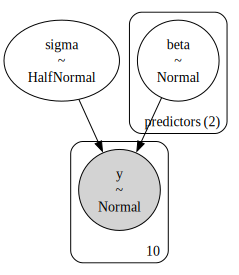

In [14]:
import pymc as pm
import pytensor.tensor as pt
import pandas as pd

X = pd.DataFrame({'x1': np.random.randn(10), 'x2': np.random.randn(10)})

with pm.Model(coords={"predictors": X.columns.values}) as model:
    sigma = pm.HalfNormal("sigma", 25)
    beta = pm.Normal("beta", mu=0, sigma=10, dims="predictors") # dims 引数で明示的に次元に名前を与える
    mu = pt.dot(X.values, beta)
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=np.random.randn(10))

pm.model_to_graphviz(model)

この例では、`beta` に `dims="predictors"` を指定することで、`beta` が `X` の列（予測変数）に対応する次元を持つことを明示的に示しています。
これにより、結果を分析する際に、どの係数がどの予測変数に対応するかを簡単に把握できます。

### まとめ

*   PyMCでは、**サポート次元、バッチ次元、暗黙的な次元、明示的な次元**の4種類の次元を理解することが重要です。
*   **`shape`引数**でバッチ次元を指定し、**`dims`引数**で次元に名前を付けることができます。
*   **`coords`引数**で次元名と座標値を対応させることができます。
*   これらの次元指定を理解することで、**より複雑なモデルを柔軟に構築し、可読性の高いコードを書く**ことができます。

### PyMCにおける一般化線形モデル（GLM）

一般化線形モデル（GLM）は、統計モデリングにおいて非常に重要なツールであり、**さまざまなタイプのデータを分析するための柔軟なフレームワーク**を提供します。PyMCでは、このGLMを**ベイズ統計の枠組みで**構築することができます。

#### 古典的な線形回帰との比較

*   **古典的な線形回帰**では、以下のようにモデルが表現されます:

    $ Y = X\beta + \epsilon $

    ここで、$Y$ は予測したい出力（従属変数）、$X$ は予測変数（独立変数）、$\beta$ はモデルの係数（パラメータ）、そして $\epsilon$ は誤差項であり、通常は正規分布に従うと仮定されます。
    古典的なアプローチでは、最小二乗法や最尤法を用いて、最適な $\beta$ を求めます。
*   **ベイズ的な線形回帰**では、同じモデルを確率分布を用いて表現します:

    $ Y \sim \mathcal{N}(X \beta, \sigma^2) $

    この場合、$Y$ は正規分布に従う確率変数（または確率ベクトル）と見なされ、その平均は線形予測子 $X \beta$ で、分散は $\sigma^2$ で与えられます。
    ベイズ的なアプローチでは、$\beta$ と $\sigma^2$ にも事前分布を設定し、**事後分布**を計算することで、パラメータの不確実性を考慮に入れた推論を行います。

#### ベイズ的GLMの利点

ベイズ的なGLMには、古典的なアプローチと比較して、いくつかの重要な利点があります:

*   **不確実性の定量化**: パラメータの事後分布から、パラメータの不確実性を直接的に評価できます。
*   **柔軟なモデリング**: さまざまな種類の分布を誤差項に適用できます。
*   **事前知識の組み込み**: 事前分布を用いて、パラメータに関する既存の知識をモデルに組み込むことができます。

#### PyMCでのGLMの構築

PyMCでは、以下のステップでベイズ的GLMを構築します:

1.  **必要なモジュールのインポート**: `arviz`、`matplotlib.pyplot`、`numpy`、`pandas`、`pymc` などの必要なモジュールをインポートします。
2.  **データの準備**: モデルに使用するデータを準備します。ここでは、回帰直線に基づいて、ノイズが加えられたデータを作成します。
3.  **モデルの定義**: `with pm.Model() as model:` でコンテキストマネージャを開始し、その中でモデルを定義します。
4.  **事前分布の設定**: モデルのパラメータ（例: 切片、傾き、誤差の標準偏差）に対して、事前分布を設定します。
    *   例えば、切片と傾きには正規分布、誤差の標準偏差には半コーシー分布を使用します。
    *   **半コーシー分布は、正の値のみを取る**分布であり、標準偏差のようなスケールパラメータの事前分布としてよく用いられます。
    *   `pm.HalfCauchy("sigma", beta=10)` は、半コーシー分布を定義します。
    *   `pm.Normal("Intercept", 0, sigma=20)` は、平均0、標準偏差20の正規分布を定義します。
5.  **尤度関数の定義**: 観測データが従う確率分布（尤度関数）を定義します。
    *   ここでは、正規分布を仮定します。
    *   `pm.Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)` は、平均が `intercept + slope * x` 、標準偏差が `sigma` の正規分布を定義し、`observed=y` で観測データ `y` を指定します。
6.  **サンプリングの実行**: `pm.sample(3000)` を使用して、事後分布からのサンプルを生成します。デフォルトでは、NUTSサンプラーが使用されます。

#### コード例

以下に、PyMCで線形回帰モデルを構築する例を示します:

In [15]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

# データの生成
size = 200
true_intercept = 1
true_slope = 2
x = np.linspace(0, 1, size)
true_regression_line = true_intercept + true_slope * x
rng = np.random.default_rng(8927)
y = true_regression_line + rng.normal(scale=0.5, size=size)
data = pd.DataFrame({"x": x, "y": y})

# モデルの定義
with pm.Model() as model:
    sigma = pm.HalfCauchy("sigma", beta=10)
    intercept = pm.Normal("Intercept", 0, sigma=20)
    slope = pm.Normal("slope", 0, sigma=20)
    likelihood = pm.Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)

    # サンプリングの実行
    idata = pm.sample(3000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.


1.  **標準偏差の事前分布としての半コーシー分布の一般性**

    *   ご指摘の通り、標準偏差の事前分布としては半正規分布や逆ガンマ分布もよく用いられます。
    *   **半コーシー分布は、特にPyMCのドキュメントで推奨されること**が多いですが、これは必ずしも実務上最も一般的に使われるという意味ではありません。
    *   半コーシー分布は、**裾の重い分布**であり、**事前分布の不確実性を大きく反映**させたい場合に適しています。
        *   これは、**パラメータの値が小さくなることを過度に制約せず、大きな値も取りうる**ことを意味します。
    *   半正規分布は、より裾の軽い分布であり、パラメータの値がある程度小さくなることを期待する場合に使われます。
    *   逆ガンマ分布は、正規分布の分散の共役事前分布としてよく知られていますが、ベイズモデリングでは必ずしも実務上広く用いられているわけではありません。
    *   実務上、**どの分布が最適かは、データの性質やモデルの目的、パラメータに対する事前知識によって異なります**。
    *   したがって、**半コーシー分布が「最も」一般的に使われると断言することはできませんが、PyMC環境では推奨される選択肢の一つ**として覚えておくと良いでしょう。
    *   重要なのは、**分布の特性を理解し、モデルに合った事前分布を選択する**ことです。

2.  **事前分布のパラメータ設定の根拠**

    *   ドキュメントに明示的な根拠は示されていませんが、以下のように一般論として説明できます。
    *   **半コーシー分布のbetaパラメータ**（例：`beta=10`）は、**分布のスケール**を制御します。
        *   `beta` が大きいほど、分布の裾が広がり、大きな値を取りやすくなります。
        *   ここでは、`beta=10` とすることで、標準偏差がある程度大きな値になることも許容し、**事前に標準偏差の値が小さくなることを過度に制約しないようにする意図**があると考えられます。
    *   **正規分布の標準偏差パラメータ**（例：`sigma=20`）も、**分布のスケール**を制御します。
        *   `sigma` が大きいほど、分布の裾が広がり、パラメータの不確実性が大きくなります。
        *   ここでは、`sigma=20` とすることで、切片と傾きがある程度大きな値を取ることも許容し、**パラメータに関する事前知識が少ない（弱い事前情報）ことを反映**させていると考えられます。
    *   これらのパラメータ値は、**恣意的に選ばれているわけではなく、モデリングの経験則や一般的な推奨事項に基づいている**と考えられます。
        *   **PyMCでは、デフォルトでそれほど強くない事前分布が用いられる**傾向にあります。
    *   **事前分布のパラメータ選択は、モデリングの重要な部分であり、結果に大きな影響を与える**可能性があります。
        *   したがって、**必要に応じて、パラメータに対する自分の信念や事前知識を反映させた値に変更する必要があります**。
        *   **実務上は、複数の異なるパラメータ設定を試して、モデルの感度を検証することが推奨**されます。

まとめると、**標準偏差の事前分布として半コーシー分布を用いることは、PyMC環境ではよく推奨される選択肢の一つ**ですが、他の分布も状況に応じて検討すべきです。また、**事前分布のパラメータ設定は、モデルの目的に合わせて適切に行う必要があり、経験則や事前知識に基づいて選択する必要があります**。もし、これらの選択に明確な根拠がない場合は、異なる設定を試してモデルの感度を確かめることが重要です。


#### Bambiを使用したGLMの構築

PyMCでは、**Bambi**というライブラリを使って、より簡潔にGLMを記述することもできます。Bambiは、Rのモデル記述構文に似たものを使用します。

In [16]:
import bambi as bmb
model = bmb.Model("y ~ x", data)
idata = model.fit(draws=3000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, x]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.


`"y ~ x"` は、出力変数 `y` を入力変数 `x` の線形関数として推定するという意味です。
Bambiは、モデル式を解析し、各回帰変数（この場合は切片と傾き）に対応する確率変数を自動的に追加し、尤度関数（デフォルトでは正規分布）とその他の変数（`sigma`）も追加します。

#### 事後予測チェック

モデルの適合度を評価するために、**事後予測チェック**を行います。これにより、モデルが観測データをどの程度再現できるかを確認できます。

**事後予測チェック (Posterior Predictive Checks, PPC)** は、**モデルの妥当性を検証するための重要な手法**です。これは、**事後分布から得られたパラメータを用いてモデルからデータを生成し、その生成されたデータと実際の観測データを比較する**ことで、モデルが現実のデータをどの程度再現できるかを確認します。

#### PyMCにおける事後予測チェックのステップ

1.  **モデルの構築とサンプリング**:
    *   まず、`pymc` を用いてモデルを定義し、`pm.sample()` で事後分布からのサンプルを得ます。
    *   このステップは、GLM（一般化線形モデル）の例で示したものと同様です。
2.  **事後予測サンプルの生成**:
    *   `pm.sample_posterior_predictive()` 関数を使用して、事後予測サンプルを生成します。
    *   この関数は、**事後分布からランダムにパラメータを抽出し、そのパラメータを使ってモデルからデータを生成**します。
    *   生成されたデータは、観測データの形式に対応した形式で出力されます。
3.  **予測データと観測データの比較**:
    *   生成された予測データと実際の観測データを比較し、モデルがデータをどの程度適切に再現しているか評価します。
    *   評価は、**可視化**や**統計量**を通じて行われます。

#### コード例：線形回帰モデルでの事後予測チェック

以下に、線形回帰モデルにおける事後予測チェックの具体的なコード例を示します。この例では、`Prior and Posterior Predictive Checks` のドキュメントで使用されているものと似たデータとモデルを使用します。

Sampling: [a, b, obs, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 42 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [obs]


Output()

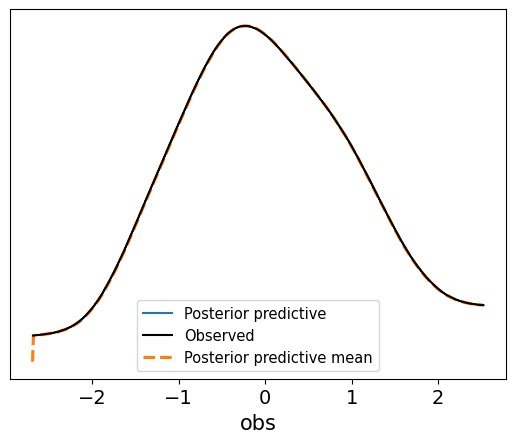

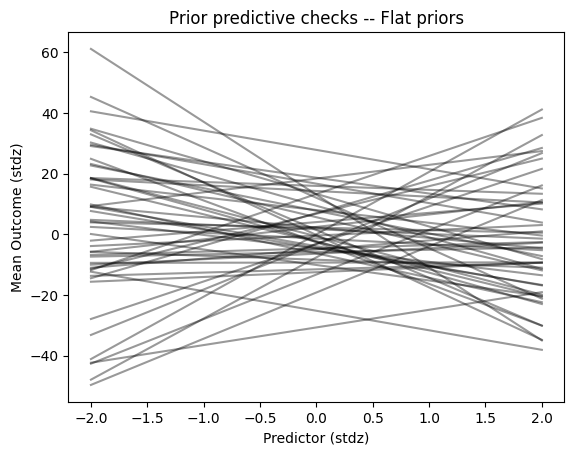

In [19]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import xarray as xr

# データの生成
N = 100
true_a, true_b, predictor = 0.5, 3.0, np.random.default_rng(58).normal(loc=2, scale=6, size=N)
true_mu = true_a + true_b * predictor
true_sd = 2.0
outcome = np.random.default_rng(58).normal(loc=true_mu, scale=true_sd, size=N)

# データの標準化
def standardize(series):
    return (series - series.mean()) / series.std()

predictor_scaled = standardize(predictor)
outcome_scaled = standardize(outcome)


# モデルの定義
with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 10.0)
    b = pm.Normal("b", 0.0, 10.0)
    mu = a + b * predictor_scaled
    sigma = pm.Exponential("sigma", 1.0)
    pm.Normal("obs", mu=mu, sigma=sigma, observed=outcome_scaled)

    # 事前予測サンプルの生成
    idata = pm.sample_prior_predictive(draws=50, random_seed=58)

    # サンプリングの実行
    idata.extend(pm.sample(1000, tune=2000, random_seed=58))

    # 事後予測サンプルの生成
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)


# 事後予測チェックの可視化
az.plot_ppc(idata, num_pp_samples=100)
plt.show()

#予測された関係の可視化
_, ax = plt.subplots()
x = xr.DataArray(np.linspace(-2, 2, 50), dims=["plot_dim"])
prior = idata.prior
y = prior["a"] + prior["b"] * x
ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)
ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Flat priors")
plt.show()


このコードでは、以下のステップを実行しています:

1.  **データの生成と標準化**:
    *   **回帰直線**に従うデータにノイズを加えたものを生成し、**予測変数**と**目的変数**を標準化しています。
    *   標準化は、サンプラーの効率を高めるためによく行われます。
2.  **モデルの定義**:
    *   **切片** (a) 、**傾き** (b) には正規分布、**誤差の標準偏差** (sigma) には指数分布を事前分布として設定した線形回帰モデルを定義しています。
    *   `pm.Normal("obs", mu=mu, sigma=sigma, observed=outcome_scaled)` で尤度関数を定義しています。
3.  **事後予測サンプルの生成**:
    *   `pm.sample_posterior_predictive(idata, extend_inferencedata=True)` を使用して、事後予測サンプルを生成し、既存の `idata` オブジェクトに追加しています。
4.  **事後予測チェックの可視化**:
    *   `az.plot_ppc(idata, num_pp_samples=100)` で、**生成された予測データの分布と実際の観測データの分布を比較**するプロットを表示します。
    *   `num_pp_samples` パラメータで、プロットに使用する予測サンプル数を指定できます。
    *   また、`Prior predictive checks` のように、事前の予測分布についてもプロットできます。

#### コード例：ロジスティック回帰モデルでの事後予測チェック

以下に、ロジスティック回帰モデルにおける事後予測チェックのコード例を示します。この例では、`Prior and Posterior Predictive Checks` のドキュメントで使用されているものと似たモデルを使用します。

In [84]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from scipy.special import expit as logistic

# データの生成
N = 400
rng = np.random.default_rng(58)
true_intercept = 0.2
true_slope = 1.0
predictors = rng.normal(size=N)
true_p = logistic(true_intercept + true_slope * predictors)
outcomes = rng.binomial(1, true_p)


with pm.Model() as model_2:
    # モデルパラメータの定義
    slope = pm.Normal("slope", mu=0.0, sigma=10)
    intercept = pm.Normal("intercept",mu=0,sigma=10)
    # 予測子変数を MutableData として定義
    pred = pm.MutableData("pred", predictors, dims="obs_id")
    # ロジスティック回帰モデルの定義
    p = pm.Deterministic(
        "p", pm.math.invlogit(betas[0] + betas[1] * pred), dims="obs_id"
    )
    # ベルヌーイ分布に従う観測データの定義
    outcome = pm.Bernoulli("outcome", p=p, observed=outcomes, dims="obs_id")

# 事後分布サンプリングの実行
with model_2:
    idata_2 = pm.sample(1000, tune=2000, return_inferencedata=True, random_seed=rng)

# 事後予測サンプリングの実行
with model_2:
    idata_2.extend(pm.sample_posterior_predictive(
        idata_2, extend_inferencedata=True, predictions=True
    ))


/Users/yutaro/Documents/source/pyMC_practice/.venv/lib/python3.10/site-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.
Sampling: [outcome]


Output()

In [85]:
idata_2

Inference data with groups:
	> posterior
	> predictions
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

In [82]:
az.plot_ppc(idata_2)

TypeError: `data` argument must have the group "posterior_predictive" for ppcplot

In [ ]:

# 事後予測チェックのためのデータの準備
predictors_out_of_sample = idata_2.constant_data["pred"].sortby(
    idata_2.constant_data["pred"]
)
model_preds = idata_2.predictions.sortby(predictors_out_of_sample)
outcomes_out_of_sample = outcomes[np.argsort(predictors)]

# 予測と不確実性の可視化
_, ax = plt.subplots(figsize=(12, 6))
ax.vlines(
    predictors_out_of_sample,
    *az.hdi(model_preds)["p"].transpose("hdi", ...),
    color="C1",
    alpha=0.2,
)
ax.plot(
    predictors_out_of_sample,
    model_preds["p"].mean(("chain", "draw")),
    "o",
    ms=5,
    color="C1",
    alpha=0.8,
    label="Expected prob.",
)
ax.scatter(
    x=predictors,
    y=outcomes,
    marker="x",
    color="k",
    alpha=0.8,
    label="Observed outcomes",
)

# 真の確率の可視化
x = np.linspace(predictors_out_of_sample.min() - 0.1, predictors_out_of_sample.max() + 0.1)
ax.plot(
    x,
    logistic(true_intercept + true_slope * x),
    lw=2,
    ls="--",
    color="#565C6C",
    alpha=0.8,
    label="True prob.",
)

ax.set_xlabel("Predictor")
ax.set_ylabel("Prob. of success")
ax.set_title("Out-of-sample Predictions")
ax.legend(fontsize=10, frameon=True, framealpha=0.5)

plt.show()



このコードでは、以下のステップを実行しています:

1.  **データの生成**:
    *   **ロジスティック関数**に従う確率で、二値の目的変数データを生成しています。
2.  **モデルの定義**:
    *   **切片**と**傾き**を表す `betas` に正規分布を事前分布として設定したロジスティック回帰モデルを定義しています。
    *   `pm.math.invlogit()` でロジスティック関数を計算し、`pm.Bernoulli()` で尤度関数を定義しています。
3.  **事後予測サンプルの生成**:
    *   `pm.sample()` でサンプリングを実行し、`pm.sample_posterior_predictive()` で事後予測サンプルを生成しています。
4.  **事後予測チェックの可視化**:
    *   生成された事後予測サンプルから予測確率を計算し、**予測された確率とその不確実性を可視化**しています。
    *   また、実際の観測データと真の確率もプロットして、モデルの予測性能を評価しています。

#### まとめ

*   **事後予測チェックは、モデルの妥当性を評価するための重要なステップ**です。
*   `pm.sample_posterior_predictive()` 関数を使用することで、事後予測サンプルを簡単に生成できます。
*   `arviz.plot_ppc()` やカスタムの可視化を用いることで、予測データと観測データを比較できます。
*   **モデルの種類や目的に応じて、適切な可視化や評価を行うことが重要**です。
*   事後予測チェックを通じて、**モデルの不適合や改善点を発見し、より精度の高いモデルを構築**することができます。

これらのコード例と説明が、事後予測チェックの理解を深めるのに役立てば幸いです。もし、さらに質問があれば、お気軽にお尋ねください。



#### まとめ

*   GLMは、さまざまなタイプのデータを分析するための柔軟なフレームワークです。
*   PyMCでは、ベイズ的なアプローチでGLMを構築できます。
*   Bambiを使うと、より簡潔な構文でGLMを記述できます。
*   事後予測チェックは、モデルの妥当性を評価するために重要です。

### 次のステップ

次は、**ガウス過程 (Gaussian Processes)** について解説します。ご質問があれば、お気軽にお尋ねください。


In [53]:
idata_2.posterior_predictive

AttributeError: 'InferenceData' object has no attribute 'posterior_predictive'